# Designing a mean estimator and comparing against FISH data

Data: https://drive.google.com/drive/folders/1uos3DDymyrh3ZyxveDhqQIcOyD1brxeL

In [244]:
import pandas as pd
import seaborn as sns
import scanpy as sc
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
import itertools

In [245]:
data_path = '/data_volume/memento/saver/'

In [246]:
dropseq = pd.read_csv('/data_volume/memento/saver/melanoma_dropseq.csv', index_col=0, sep=',').T
# dropseq = dropseq[dropseq['GAPDH'] > 0]
dropseq_sf = dropseq.sum(axis=1).values


In [247]:
smfish = pd.read_csv('/data_volume/memento/saver/fishSubset.txt', index_col=0, sep=' ')
# smfish = smfish[smfish['GAPDH'] > 0]
fish_gapdh_sf = (smfish['GAPDH']+1).values
# smfish_normalized = smfish#/fish_gapdh_sf.reshape(-1, 1)
# smfish = pd.read_csv('fishSubset (1).txt', sep=' ', index_col=0)

In [248]:
overlap_genes = list(set(dropseq.columns) & set(smfish.columns))
overlap_genes = dropseq.mean(axis=0)[overlap_genes][dropseq.mean(axis=0)[overlap_genes] > 0.02].index.tolist()

In [249]:
smfish = smfish[overlap_genes].fillna(0.0)

### Confirm SAVER computes sample mean

In [311]:
variance_contributions.shape

(8498, 12241)

In [312]:
q=0.02
X = dropseq/dropseq_sf.reshape(-1,1)
m1 = (dropseq/dropseq_sf.reshape(-1,1)).mean(axis=0)
naive_v = X.var(axis=0)
v = naive_v-(1-q)*(dropseq.values/(dropseq_sf**2-dropseq_sf*(1-q)).reshape(-1,1)).mean(axis=0)
variance_contributions = ((1-q)/dropseq_sf).reshape(-1,1)*m1.values.reshape(1,-1) + v.values.reshape(1,-1)
m3 = pd.Series(np.average( (dropseq/dropseq_sf.reshape(-1,1)), weights=1/variance_contributions, axis=0), index=m1.index)
m3[m3<0] = m1[m3<0]

In [270]:
saver_estimates = pd.read_csv('/data_volume/memento/saver/saver_estimates.csv', index_col=0)

In [321]:
m_saver = (saver_estimates/dropseq_sf.mean()).mean(axis=1)

In [322]:
stats.pearsonr(np.log(m1), np.log(m_saver)) # Pretty much identical

PearsonRResult(statistic=0.9999568794492765, pvalue=0.0)

In [323]:
stats.pearsonr(np.log(m3), np.log(m_saver)) #pretty close but not identical

PearsonRResult(statistic=0.9972203156894193, pvalue=0.0)

### Numi vs # genes plot

In [284]:
num_genes = (dropseq > 0).sum(axis=1)

Text(0, 0.5, 'num genes detected')

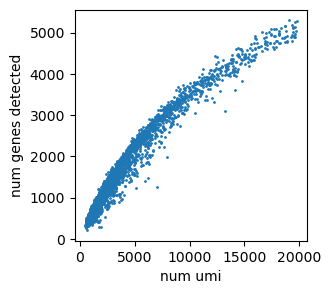

In [285]:
plt.figure(figsize=(3,3))
plt.scatter(dropseq.sum(axis=1), num_genes, s=1)
plt.xlabel('num umi');plt.ylabel('num genes detected')

### Function for comparing estimators using FISH data

In [101]:
def compare_estimators(smfish, fish_gapdh_sf, dropseq, dropseq_sf, overlap_genes,p=1):

    q=0.02*p
    mfish = (smfish/fish_gapdh_sf.reshape(-1,1))[overlap_genes].mean(axis=0)

    # Sample mean
    m1 = (dropseq/dropseq_sf.reshape(-1,1))[overlap_genes].mean(axis=0)

    # Filtering cells
    cells_with_many_genes = (dropseq_sf > 1500*p)
    m2 = (dropseq/dropseq_sf.reshape(-1,1)).loc[cells_with_many_genes,overlap_genes].mean(axis=0)
    m2 = np.maximum(m1,m2)

    # Solve for optimal weights
    X = dropseq/dropseq_sf.reshape(-1,1)
    naive_v = X.var(axis=0)[overlap_genes]
    v = naive_v-(1-q)*(dropseq[overlap_genes].values/(dropseq_sf**2-dropseq_sf*(1-q)).reshape(-1,1)).mean(axis=0)
    variance_contributions = ((1-q)/dropseq_sf).reshape(-1,1)*m1.values.reshape(1,-1) + v.values.reshape(1,-1)
    m3 = pd.Series(np.average( (dropseq/dropseq_sf.reshape(-1,1))[overlap_genes], weights=1/variance_contributions, axis=0), index=m2.index)
    m3[m3<0] = m2[m3<0]

    return mfish, m1, m2, m3
    plt.scatter(x=np.log(mfish), y=np.log(m1))
    plt.scatter(x=np.log(mfish), y=np.log(m2))
    plt.scatter(x=np.log(mfish), y=np.log(m3))

    plt.xlabel('FISH'); plt.ylabel('Dropseq');
    plt.legend(['naive r=%0.2f' % stats.pearsonr(np.log(mfish), np.log(m1))[0], 
                'filtered r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m2))[0], 
                'weighted r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m3))[0],
               ])

### Investigate performance with varying number of cells

In [332]:
result = []
for num_cell in [50, 100, 200, 300, 500, 1000]:
        
        for trial in range(1000):

            sample_idx = np.random.choice(dropseq.shape[0], num_cell)
            tiny = dropseq.iloc[sample_idx]
            shallow = tiny
            counts = shallow.sum(axis=0)[overlap_genes]
            relevant_genes = counts[counts > 0].index.tolist()
            shallow_sf = shallow.sum(axis=1).values
            mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, shallow, shallow_sf, overlap_genes=relevant_genes, p=p)

            mean_numi = shallow_sf.mean()
            
            corr1 = stats.pearsonr(np.log(mfish), np.log(m1))[0]
            corr2 = stats.pearsonr(np.log(mfish), np.log(m2))[0]
            corr3 = stats.pearsonr(np.log(mfish), np.log(m3))[0]
            result.append((num_cell, p, mean_numi, corr1, corr2, corr3))
experiment_result = pd.DataFrame(result, columns=['num_cell', 'p', 'mean_umi', 'naive', 'filtered', 'memento'])
experiment_result.to_csv('numcells.csv', index=False)

In [333]:
df = pd.melt(experiment_result, id_vars=['num_cell', 'p', 'mean_umi'], value_vars=['naive', 'memento'], var_name='estimator')

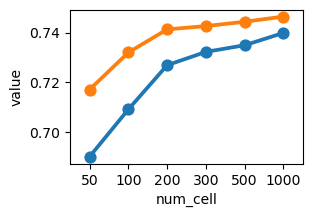

In [334]:
plt.figure(figsize=(3, 2))
sns.pointplot(y='value', x='num_cell', hue='estimator',data=df, errorbar=('ci', 0), estimator='median')
# sns.stripplot(y='value', x='p', hue='estimator',data=df, dodge=True, alpha=0.2,s=3)
plt.legend([], frameon=False)

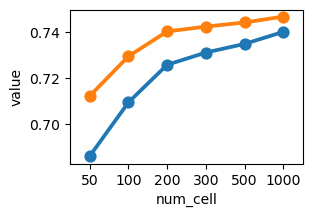

In [335]:
plt.figure(figsize=(3, 2))
sns.pointplot(y='value', x='num_cell', hue='estimator',data=df, errorbar=('ci', 0), estimator='mean')
# sns.stripplot(y='value', x='p', hue='estimator',data=df, dodge=True, alpha=0.2,s=3)
plt.legend([], frameon=False)

### Investigate performance with varying number of UMIs per cell

In [ ]:
result = []
num_cell = 200
for p in [0.5, 0.7, 0.9, 1]:
        
        for trial in range(1000):

            sample_idx = np.random.choice(dropseq.shape[0], num_cell)
            tiny = dropseq.iloc[sample_idx]
    
            shallow = pd.DataFrame(stats.binom.rvs(tiny, p=p), columns=tiny.columns)
            relevant_genes = counts[counts > 0].index.tolist()
            shallow_sf = shallow.sum(axis=1).values
            mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, shallow, shallow_sf, overlap_genes=relevant_genes, p=p)

            mean_numi = shallow_sf.mean()
            
            try:
                corr1 = stats.pearsonr(np.log(mfish), np.log(m1))[0]
                corr2 = stats.pearsonr(np.log(mfish), np.log(m2))[0]
                corr3 = stats.pearsonr(np.log(mfish), np.log(m3))[0]
                result.append((num_cell, p, mean_numi, corr1, corr2, corr3))
            except:
                continue
experiment_result = pd.DataFrame(result, columns=['num_cell', 'p', 'mean_umi', 'naive', 'filtered', 'memento'])
experiment_result.to_csv('numi.csv', index=False)

/tmp/ipykernel_4926/2380475113.py:19: RuntimeWarning: divide by zero encountered in true_divide
  m3 = pd.Series(np.average( (dropseq/dropseq_sf.reshape(-1,1))[overlap_genes], weights=1/variance_contributions, axis=0), index=m2.index)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/numpy/lib/function_base.py:527: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4446: RuntimeWarning: invalid value encountered in subtract
  ym = y.astype(dtype) - ymean
/tmp/ipykernel_4926/2380475113.py:19: RuntimeWarning: divide by zero encountered in true_divide
  m3 = pd.Series(np.average( (dropseq/dropseq_sf.reshape(-1,1)

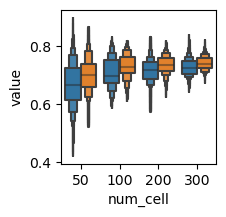

In [224]:
plt.figure(figsize=(2, 2))
sns.boxenplot(y='value', x='num_cell', hue='estimator',data=df, showfliers=False, k_depth=10)
# sns.stripplot(y='value', x='p', hue='estimator',data=df, dodge=True, alpha=0.2,s=3)
plt.legend([], frameon=False)

In [223]:
tiny = dropseq.iloc[sample_idx]
tiny_sf = dropseq_sf[sample_idx]
mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, tiny, tiny_sf)

p=0.1
shallow = pd.DataFrame(stats.binom.rvs(tiny, p=p), columns=dropseq.columns)
shallow_sf = shallow.sum(axis=1).values
mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, shallow, shallow_sf, p=p)

plt.scatter(x=np.log(mfish), y=np.log(m1))
plt.scatter(x=np.log(mfish), y=np.log(m2))
plt.scatter(x=np.log(mfish), y=np.log(m3))

plt.xlabel('FISH'); plt.ylabel('Dropseq');
plt.legend(['naive r=%0.2f' % stats.pearsonr(np.log(mfish), np.log(m1))[0], 
            'filtered r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m2))[0], 
            'weighted r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m3))[0],
           ])

TypeError: compare_estimators() missing 1 required positional argument: 'overlap_genes'

In [187]:
plt.scatter(np.log(mfish), np.log(m1*mmfish/mm1))
# plt.scatter(np.log(mfish), np.log(m2))
plt.scatter(np.log(mfish), np.log(m3*mmfish/mm3))
# plt.scatter(np.log(mfish), np.log(m4))

plt.xlabel('FISH'); plt.ylabel('Dropseq');
plt.legend(['naive r=%0.2f' % stats.pearsonr(np.log(mfish), np.log(m1*mmfish/mm1))[0], 
            # 'filtered r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m2))[0], 
            'weighted r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m3*mmfish/mm3))[0],
            # 'medofmean r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m4))[0] 
           ])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'mm1' is not defined

/tmp/ipykernel_22844/300944203.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(mfish), np.log(m4))


ValueError: array must not contain infs or NaNs

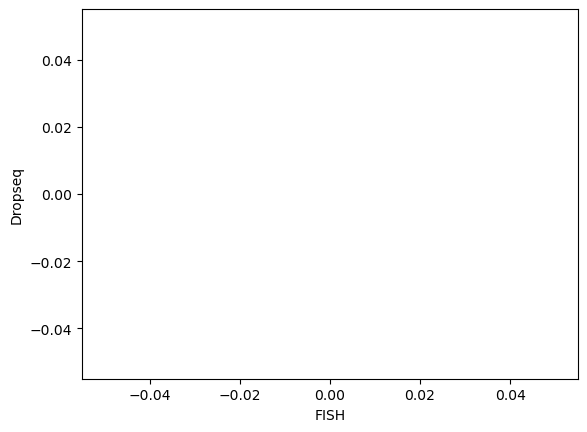

In [188]:
plt.scatter(np.log(mfish), np.log(m1))
plt.scatter(np.log(mfish), np.log(m2))
# plt.scatter(np.log(mfish), np.log(m3))
plt.scatter(np.log(mfish), np.log(m4))

plt.xlabel('FISH'); plt.ylabel('Dropseq');
plt.legend(['naive r=%0.2f' % stats.pearsonr(np.log(mfish), np.log(m1))[0], 
            'filtered r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m2))[0], 
            'medofmean r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m4))[0] ])

### Test with simple generative model

In [181]:
Nc = dropseq_sf/0.05
Mc = dropseq_sf

In [199]:
sampling_dist1 = np.zeros(5000)
for trial in range(5000):
    Z = stats.poisson.rvs(Nc*1e-5, size=Nc.shape[0])
    Y = stats.binom.rvs(Z, 0.05)
    estimate1 = (Y/Mc).mean()
    sampling_dist1[trial] = estimate1

In [200]:
sampling_dist1.mean()

9.994229215738449e-06

<AxesSubplot: ylabel='Density'>

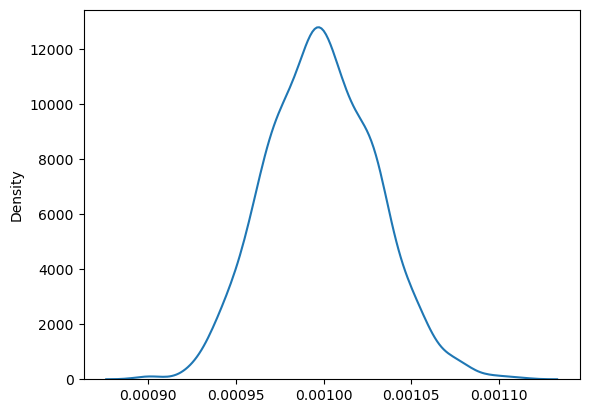

In [155]:
sns.kdeplot(sampling_dist1)

In [152]:
estimate = (Y/Mc).mean()

In [153]:
estimate

0.0009475896876039991

### Run memento for DropSeq

In [9]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [53]:
adata = sc.AnnData(X=sparse.csr_matrix(dropseq.values), obs=pd.DataFrame(index=dropseq.index), var=pd.DataFrame(index=dropseq.columns))
q = 0.01485030176341905
adata.obs['q'] = q
adata.obs['group'] = 'A'
adata.write(data_path + 'dropseq.h5ad')

memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.02,trim_percent=0.5, shrinkage=0)

#Optional
mem_gapdh_sf = (adata[:, 'GAPDH'].X.todense().A1+1)/( adata[:, 'GAPDH'].X.todense().A1+1).mean()
mem_total_sf = adata.obs['memento_size_factor']/adata.obs['memento_size_factor'].mean()
adata.obs['memento_size_factor'] = 1

memento.create_groups(adata, label_columns=['group'])
memento.compute_1d_moments(adata, filter_genes=True)

dropseq_m, dropseq_v, _ = adata.uns['memento']['1d_moments']['sg^A']
dropseq_fano = dropseq_v/dropseq_m**2

naive_sf = dropseq.sum(axis=1).values/adata.X.sum(axis=1).mean()
naive_sf = 1# adata.obs['memento_size_factor'].values

normalized_dropseq = adata.X.toarray()/naive_sf
naive_m, naive_v = normalized_dropseq.mean(axis=0), normalized_dropseq.var(axis=0)
naive_fano = naive_v/naive_m**2

... storing 'group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


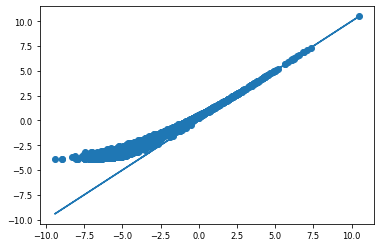

In [54]:
plt.scatter(np.log(dropseq_v), np.log(naive_v))
plt.plot(np.log(dropseq_v),np.log(dropseq_v))

### Compute fish mean and variance

In [55]:
keep_genes = smfish.columns.tolist()
overlap_genes = list(set(adata.var.index) & set(keep_genes))
overlap_gene_idxs = np.array([adata.var.index.tolist().index(g) for g in overlap_genes])

dropseq_m, dropseq_v, naive_m, naive_v = dropseq_m[overlap_gene_idxs], dropseq_v[overlap_gene_idxs], naive_m[overlap_gene_idxs], naive_v[overlap_gene_idxs]
dropseq_fano, naive_fano = dropseq_fano[overlap_gene_idxs], naive_fano[overlap_gene_idxs]

filtered_smfish = smfish_normalized[overlap_genes]

means = np.nanmean(filtered_smfish, axis=0)
variances = np.nanvar(filtered_smfish, axis=0)
corrs = filtered_smfish.corr()
covs = filtered_smfish.cov()
fanos = variances/means**2

naive_corr = np.corrcoef(normalized_dropseq[:, overlap_gene_idxs], rowvar=False)
naive_cov = np.cov(normalized_dropseq[:, overlap_gene_idxs], rowvar=False)


### Make comparison for mean and variability

In [56]:
filtered_saver = normalized_saver_estimates[overlap_genes]

In [57]:
saver_m = np.nanmean(filtered_saver, axis=0)
saver_v = np.nanvar(filtered_saver, axis=0)
saver_fano = saver_v/saver_m**2

a, b, _, _, _= stats.linregress(np.log(saver_m), np.log(saver_v))
naive_rv = np.log(saver_v)-(np.log(saver_m)*a+b)

In [58]:
n_umi = adata.obs['memento_size_factor'].mean()

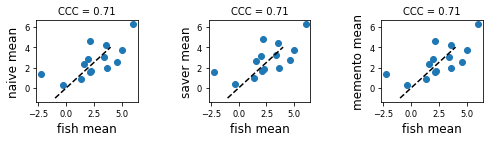

In [59]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(means), np.log(naive_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('naive mean')
plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(naive_m/q))[0]))

plt.subplot(1,3,2)
plt.scatter(np.log(means), np.log(saver_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('saver mean')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(saver_m/q))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(means), np.log(dropseq_m*n_umi/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('memento fmean')
plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(dropseq_m*n_umi/q))[0]))

plt.savefig('mean_comparisons.png', dpi=300)

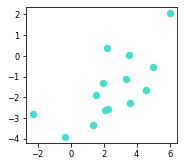

In [120]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(np.log(means), np.log(dropseq_m), s=40, color='turquoise')
# plt.xlabel('smFISH log(CV)'); plt.ylabel('Dropseq log(CV)');
plt.savefig('mean_comparisons.pdf', bbox_inches='tight')

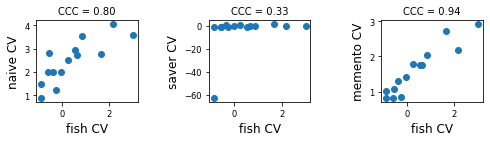

In [80]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(fanos), np.log(naive_fano))
plt.xlabel('fish CV'); plt.ylabel('naive CV')
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(naive_fano))[0]))

plt.subplot(1,3,2)
plt.scatter(np.log(fanos), np.log(saver_fano))
plt.xlabel('fish CV'); plt.ylabel('saver CV')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(saver_fano))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(fanos), np.log(dropseq_fano))
plt.xlabel('fish CV'); plt.ylabel('memento CV')
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(dropseq_fano))[0]))

plt.savefig('variability_comparisons.png', dpi=300)

In [122]:
result_path = '/data_volume/memento/saver/'

In [128]:
mean = pd.read_csv(result_path + 'dropseq_BASiCS_mu.csv'.format(q)).mean(axis=0)
delta = pd.read_csv(result_path + 'dropseq_BASiCS_delta.csv'.format(q)).mean(axis=0)
v_basics = mean+delta*mean**2
m_basics = mean
fano_basics = v_basics/m_basics**2

# scaling = (/m_basics)
# m_basics = m_basics*scaling
# v_basics = v_basics*scaling**2


In [137]:
print('memento', stats.pearsonr(np.log(fanos), np.log(dropseq_fano))[0])
print('naive', stats.pearsonr(np.log(fanos), np.log(naive_fano))[0])
print('basics', stats.pearsonr(np.log(fanos), np.log(fano_basics[overlap_genes]))[0])

memento 0.9405861170710372
naive 0.8048828841819847
basics 0.6088417637046718


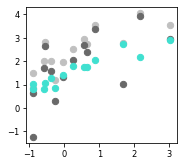

In [135]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(np.log(fanos), np.log(naive_fano), s=40, color='silver')
plt.scatter(np.log(fanos), np.log(fano_basics[overlap_genes]), s=40, color='dimgrey')
plt.scatter(np.log(fanos), np.log(dropseq_fano), s=40, color='turquoise')

# plt.xlabel('smFISH log(CV)'); plt.ylabel('Dropseq log(CV)');
plt.savefig('variability_comparisons.pdf', bbox_inches='tight')

### Make comparison for correlations

In [82]:
saver_corrs = saver_corrs_all.loc[overlap_genes, overlap_genes].values.reshape(-1)

In [83]:
memento.compute_2d_moments(adata, gene_pairs=list(itertools.product(overlap_genes, overlap_genes)))

In [84]:
memento_corr_array = adata.uns['memento']['2d_moments']['sg^A']['corr']
memento_cov_array = adata.uns['memento']['2d_moments']['sg^A']['cov']

In [85]:
fish_corr_array = np.array([corrs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])
fish_cov_array = np.array([covs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])

In [86]:
selected_pairs = ~np.isnan(fish_corr_array) & (fish_corr_array!=1)

In [87]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


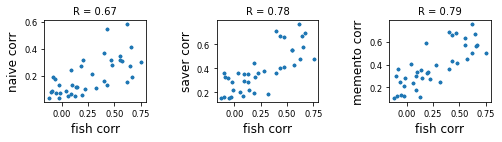

In [88]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs], s=7)
plt.xlabel('fish corr'); plt.ylabel('naive corr')
# print('naive', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0]))



plt.subplot(1,3,2)
plt.scatter(fish_corr_array[selected_pairs], saver_corrs[selected_pairs], s=7)
plt.xlabel('fish corr'); plt.ylabel('saver corr')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0]))

plt.subplot(1,3,3)
plt.scatter(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs], s=7)
plt.xlabel('fish corr'); plt.ylabel('memento corr')
# print('memento', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0])
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0]))

plt.savefig('coex_comparisons.png', dpi=300)

In [104]:
stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0]

0.7909050220217199

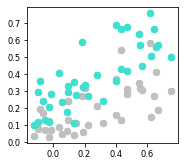

In [119]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs], s=40, color='silver')
plt.scatter(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs], s=40, color='turquoise')
# plt.xlabel('smFISH corr'); plt.ylabel('Dropseq corr');
plt.savefig('correlation_comparisons.pdf', bbox_inches='tight')